In the following notebook we consider a latent 2-dimensional VAR(2) example, i.e. where the latent process is governed by
$$
    (z_{t,1}, z_{t,2}) = (z_{t-2,1}, z_{t-2,2}, z_{t-1,1}, z_{t-1,2})  M_2(\beta) + \epsilon_{t}^\top,
$$
where $M(\beta) = (0.5\ 0.0;\ 0.0\ 0.5;\ 0.5\ 0.0;\ 0.5\ 0.5)$ and $\epsilon_t \sim \mathcal{N}\big((0,0), (1\ \rho; \rho\ 1)\big)$ for $\rho = 0.7$, independently for all $t$. Of particular interest is the resulting inference for the correlation parameter $\rho$, as well as the posterior distribution on the regression coefficients.

In [1]:
# Load required packages
using Random, Distributions, StatsPlots, AdvancedHMC, LogDensityProblems, MCMCChains, LinearAlgebra, AbstractMCMC
include(joinpath(@__DIR__, "..", "src", "ImplicitSVARCop.jl"))
using .ImplicitSVARCop

In [ ]:
function simulate_VARdata(rng::Random.AbstractRNG, T::Int; corr::Real)
    r2 = 1.0 # Perhaps we need to adjust these to get a more favorable SNR ratio.
    r3 = 1.0

    p = 2
    
    # True parameters
    Λ = Diagonal([r2, r3])
    R = [1.0 corr; corr 1.0]
    V_ϵ = Symmetric(Λ * R * Λ)
    βmat = [
        0.2 0.0;
        0.0 0.3;
        0.1 0.0;
        0.4 0.4
    ]

    ϵ = transpose(rand(rng, MvNormal(zeros(2), V_ϵ), T))
    
    # Simulate from a copula to introduce dependence between covariates
    x = transpose(cdf.(Normal(), rand(rng, MvNormal(zeros(2), [1.0 0.4; 0.4 1.0]), T)))

    # Copula scale:
    z = zeros((T, 2))
    z[1,:] = rand(rng, MvNormal(zeros(2), I))
    z[2,:] = rand(rng, MvNormal(zeros(2), I))
    for t in p+1:T
        z[t,:] = transpose(vcat(z[t-2,:], z[t-1,:])) * βmat + transpose(ϵ[t,:])
    end
    u = cdf(Normal(), z)
    y = quantile(Gamma(3, 2), u)
    return x, y
end

function run_example_VAR2(T::Int)
    rng = Random.Xoshiro(1)

    # Simulate the data:
    p = 2 # Order of process
    corr = 0.7
    x, y = simulate_VARdata(rng, T; corr=corr)

    # Estimate marginal density and transform data to latent scale:
    My = copy(y)
    Mz_est, kdests = fit_marginals(My, SSVKernel()) # Fit kernel estimates to each marginal using the Shimazaki-Shinmoto adaptive kernel estimator.
    z_est = vec(Mz_est)

    # Set up the design matrix
    F = hcat(
        Mz_est[1:T-2,:], # Lag 2, as in paper
        Mz_est[2:T-1,:]  # Lag 1, as in paper
    )

    # Create VARModel object:
    K = 2
    J = K*p
    M = 1
    df_ξ = 1.0
    model = VARModel(vec(Mz_est[p+1:end,:]), F, K, J, M, T-p; df_ξ=df_ξ)

    # Number of samples, adaptation steps
    n_samples, n_adapts = 10_000, 2_000

    D = 2*K*J+K+1
    θ_init = rand(rng, Normal(), D)

    # Specify which samplers to use for ξ and ρ in unconstrained space
    sampler_ξ = NUTS(0.75)
    sampler_ρ = NUTS(0.75)

    # Run the NUTS sampler
    samples = composite_gibbs_abstractmcmc_lkj(rng, model, sampler_ξ, sampler_ρ, θ_init, n_samples; n_adapts=n_adapts, progress=true)

    # Adaptation steps are treated as burn-in and are subsequently discarded
    chain = MCMCChains.Chains(samples[n_adapts:end], ImplicitSVARCop.get_varsymbols_lkj(model))
    samp_ρ = tanh.(vec(chain["atanh_ρ[1]"].data))  # The correlation parameter is sampled in an unconstrained space via, i.e. the sampler is targetting atanth(ρ).

    # Run variational inference
    viposterior, ELBOs = fitBayesianSVARCopVI_lkj(rng, model, 5000, 15; progress=false) # Dimension of B is dim × 15. To fit the model, we use 5000 SGA iterations. Also, VI is so fast there is no need to record the progress.
    return samp_ρ, viposterior
end

run_example_VAR2 (generic function with 1 method)

We now run the code for different sample sizes:

In [21]:
# Run the MCMC algorithm and variational inference (takes about 15 mins to run on my machine)
samples_ρ = Vector{Float64}[]
viposteriors = []
sample_sizes = [100, 400, 1500, 5000]
for T in sample_sizes
    mcmc, viposterior = run_example_VAR2(T)
    push!(samples_ρ, mcmc)
    push!(viposteriors, viposterior)
end

┌ Info: Found initial step size 0.0125
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
┌ Info: Found initial step size 0.025
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
Generating samples 100%|███████████████████████████████| Time: 0:00:04
┌ Info: Found initial step size 0.0015625
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
┌ Info: Found initial step size 0.003125
└ @ AdvancedHMC C:\Users\yr4426\.julia\packages\AdvancedHMC\5UkSY\src\abstractmcmc.jl:340
Generating samples 100%|███████████████████████████████| Time: 0:00:12
Optimizing ELBO  20%|███████                        |  ETA: 0:00:01
Optimizing ELBO  41%|█████████████                  |  ETA: 0:00:00
Optimizing ELBO  61%|███████████████████            |  ETA: 0:00:00
Optimizing ELBO  78%|█████████████████████████      |  ETA: 0:00:00
Optimizing ELBO  95%|██████████████████████████████ |  ETA: 0:00:0

In [22]:
# Get posterior means, medians:
stats_mcmc = Matrix{Any}(undef, length(sample_sizes)+1, 4)
stats_vi = Matrix{Any}(undef, length(sample_sizes)+1, 4)
stats_mcmc[1,:] = [:N, :mean_ρ, :median_ρ, :std_ρ]
stats_vi[1,:] = [:N, :mean_ρ, :median_ρ, :std_ρ]
for i in eachindex(samples_ρ)
    # MCMC
    stats_mcmc[i+1,:] .= [sample_sizes[i], mean(samples_ρ[i]), median(samples_ρ[i]), std(samples_ρ[i])]

    # VI
    # To get means, medians and standard deviations of the transformed parameter we just use Monte Carlo simulations for simplicity. (Numeric quadrature is also possible)
    ρ_vi = tanh.(rand(viposteriors[i], 1000)[end,:])
    stats_vi[i+1,:] .= [sample_sizes[i], mean(ρ_vi), median(ρ_vi), std(ρ_vi)]
end

# Plot KDE of posterior distribution
p1 = plot(xlims = [0.2, 0.8], xlabel = "ρ", ylabel="Density")
for i in eachindex(samples_ρ)
    density!(p1, samples_ρ[i], label="n = $(sample_sizes[i])")
end
vline!(p1, [0.5], color=:purple, linestyle=:dot, label="True value")
nothing

We now plot the posterior distributions of $\rho$ from VI and from MCMC and compute various summary statistics:

In [36]:
ps = []
xlims_ps = [[0.4, 1.0], [0.6, 0.95], [0.60, 0.90], [0.6, 0.9]]
t = LinRange(-1+1e-10, 1-1e-10, 1001)
for i in eachindex(sample_sizes)
    viposterior = viposteriors[i]
    μ = viposterior.μ[end]
    σ = sqrt(cov(viposterior)[end, end])

    pl = plot(xlabel="ρ", title="n = $(sample_sizes[i])", xlims=xlims_ps[i], legend=false)
    density!(pl, samples_ρ[i], label="")
    plot!(pl, t, pdf.(Normal(μ, σ), atanh.(t))./(1 .- abs2.(t)), label="")
    vline!(pl, [0.7], color=:purple, linestyle=:dot, label="")
    push!(ps, pl)
end


plegend = plot([0.0, 1.0], [0,0], lims=(0,1), legendfontsize=15, legend=:outerleft,
        fg_color_legend = nothing, label="MCMC", frame=:none, legendlinewidth=3)
plot!([0.0, 1.0], [0,0], label = "VI")
plot!([0.0, 1.0], [0,0], label = "True value", color=:purple, linestyle=:dash)
nothing

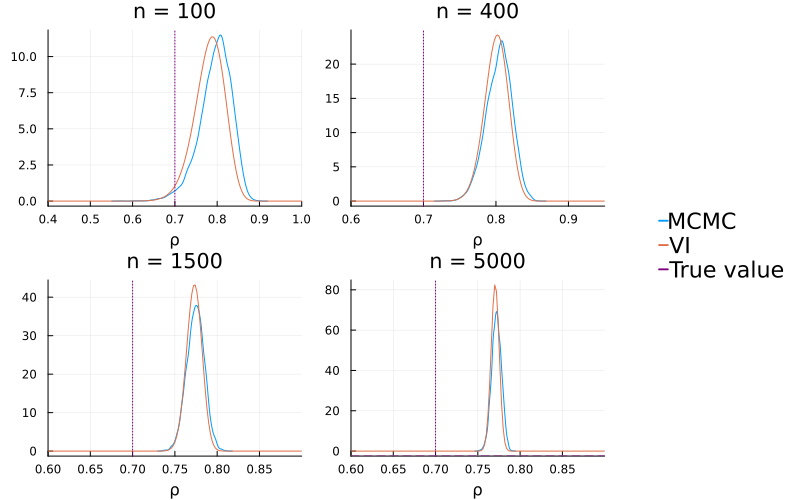

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [37]:
layout = @layout [grid(2,2) a{0.19w}]
p = plot(ps[1], ps[2], ps[3], ps[4], plegend, 
    layout = layout, size=(800,500))